In [16]:
# Code borrowed from https://github.com/stephanie-wang/ownership-osdi20/blob/master/data/Video%20stabilization%20latency.ipynb

import numpy as np
import os

def load(filename):
    results = []
    num_over_1000 = 0
    max_frame = -1
    with open(filename, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            try:
                _, frame, latency = line.split(' ')
            except:
                print(filename, line)
            frame = int(frame)
            latency = float(latency)
            results.append((frame, latency))
            if frame > max_frame:
                max_frame = frame
    start = 0
    end = max_frame
#     start = max_frame // 4
#     end = max_frame - start

    results = [latency * 1000 for frame, latency in results if frame > start and frame < end]
    print(filename)
    print("\tmean", np.mean(results))
    print("\tp50:", np.percentile(results, 50))
    print("\tp90:", np.percentile(results, 90))
    print("\tp99:", np.percentile(results, 99))
    print("\tp100:", np.max(results))
    return results

In [20]:
template = "{}-output{}.txt"

APP_KEEP_FRAMES = template.format("app_keep_frames", "")
APP_LOSE_FRAMES = template.format("app_lose_frames", "")
CHECKPOINT = template.format("checkpoint", "")

APP_KEEP_FRAMES_FAILURE = template.format("app_keep_frames", "-failure")
APP_LOSE_FRAMES_FAILURE = template.format("app_lose_frames", "-failure")
CHECKPOINT_FAILURE = template.format("checkpoint", "-failure")

filenames = [APP_KEEP_FRAMES, APP_LOSE_FRAMES, CHECKPOINT]
failure_filenames = [APP_KEEP_FRAMES_FAILURE, APP_LOSE_FRAMES_FAILURE, CHECKPOINT_FAILURE]
results = {}
for f in filenames:
    results[f] = load(f)
for f in failure_filenames:
    results[f] = load(f)

app_keep_frames-output.txt
	mean 16.613213860209864
	p50: 15.958786010742188
	p90: 25.008153915405273
	p99: 31.151790618896463
	p100: 39.99829292297363
app_lose_frames-output.txt
	mean 16.93969316019285
	p50: 14.337301254272461
	p90: 27.039051055908196
	p99: 43.919210433959954
	p100: 59.6776008605957
checkpoint-output.txt
	mean 13.28077148552516
	p50: 11.213541030883789
	p90: 22.00145721435547
	p99: 30.894336700439442
	p100: 34.92546081542969
app_keep_frames-output-failure.txt
	mean 15.994915810462018
	p50: 14.259576797485352
	p90: 24.959230422973633
	p99: 34.14135932922362
	p100: 40.241241455078125
app_lose_frames-output-failure.txt
	mean 16.313451648558548
	p50: 14.823675155639648
	p90: 25.659918785095215
	p99: 37.52642869949338
	p100: 76.16186141967773
checkpoint-output-failure.txt
	mean 56.57894567428921
	p50: 12.672901153564453
	p90: 27.864837646484375
	p99: 1024.4692325592034
	p100: 1180.0119876861572


/home/swang/anaconda3/envs/ray-wheel/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/swang/anaconda3/envs/ray-wheel/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


<Figure size 432x288 with 0 Axes>

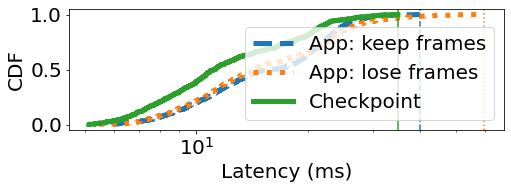

In [27]:
import matplotlib.pyplot as plt
from datetime import datetime

SAVE = True
FAILURE = False
DIR = "graphs"

font = {'size': 20}
plt.rc('font', **font)
plt.tight_layout()


index = 0
plt.figure(figsize=(7.5, 3))

def plot(curve, label, linestyle):
    global index
    color = next(plt.axes()._get_lines.prop_cycler)['color']
    n = np.arange(1,len(curve)+1) / np.float(len(curve))
    h, = plt.step(np.sort(curve), n, label=label, linewidth=5, linestyle=linestyle, color=color)
    plt.axvline(max(curve), linestyle=linestyle, color=color)
    index += 1
    return h

if FAILURE:
    curves = [
        (results[APP_KEEP_FRAMES_FAILURE], "App: keep frames, failure", 'dashed'),
        (results[APP_LOSE_FRAMES_FAILURE], "App: lose frames, failure", 'dotted'),
        (results[CHECKPOINT_FAILURE], "Checkpoint, failure", 'solid'),
    ]
else:
    curves = [
        (results[APP_KEEP_FRAMES], "App: keep frames", 'dashed'),
        (results[APP_LOSE_FRAMES], "App: lose frames", 'dotted'),
        (results[CHECKPOINT], "Checkpoint", 'solid'),
    ]

handles = [None for _ in curves]
labels = [None for _ in curves]
for i, curve in enumerate(curves):
    curve, label, linestyle = curve
    curve = [p for p in curve]
    handles[i] = plot(curve, label, linestyle)
    labels[i] = label
plt.xlabel("Latency (ms)")
plt.xscale('log')
plt.ylabel("CDF")
plt.legend()
plt.tight_layout()

if SAVE:
    plt.savefig(os.path.join(DIR, name))
else:
    plt.show()